In [1]:
# # ---------------------------- Updated Code for Jupyter Notebook ----------------------------

# # Import necessary libraries 
# import pandas as pd
# import re
# import unicodedata

# # Function to clean text by removing punctuation and converting to lowercase, retaining diacritics
# def clean_text_for_matching(text):
#     """
#     Cleans the input text for matching by removing punctuation and converting to lowercase,
#     while retaining diacritics (accents).
#     """
#     # Remove punctuation using regex
#     text = re.sub(r'[^\w\s]', '', text)
#     # Convert to lowercase
#     text = text.lower()
#     # Retain diacritics by skipping the normalization step that removes them
#     return text

# # Function to preprocess the lexicon and create translation dictionaries for all language pairs
# def create_translation_dicts(df, languages):
#     """
#     Creates translation dictionaries mapping from any source language to any target language.

#     Args:
#         df (pd.DataFrame): The lexicon DataFrame.
#         languages (list): List of supported languages.

#     Returns:
#         translation_dicts (dict): Nested dictionary for translations from source to target languages.
#                                    Structure: {source_lang: {target_lang: {source_phrase: target_phrase}}}
#     """
#     translation_dicts = {src: {tgt: {} for tgt in languages if tgt != src} for src in languages}

#     for _, row in df.iterrows():
#         for src in languages:
#             source_phrase = str(row[src]).strip().lower()
#             if pd.isna(source_phrase) or source_phrase == '':
#                 continue
#             for tgt in languages:
#                 if tgt == src:
#                     continue
#                 target_phrase = str(row[tgt]).strip().lower()
#                 if pd.isna(target_phrase) or target_phrase == '':
#                     continue
#                 translation_dicts[src][tgt][source_phrase] = target_phrase

#     return translation_dicts

# # Function for sentiment computation based on custom logic
# def compute_sentiment_v2(scores):
#     """
#     Computes sentiment based on the rules:
#     - If one score, return it.
#     - If two scores, return the one with the higher absolute value.
#     - If three or more scores, return the average of the majority group (positive or negative).
#     """
#     if len(scores) == 1:
#         return scores[0]
#     elif len(scores) == 2:
#         return max(scores, key=abs)
#     else:
#         positive_scores = [s for s in scores if s > 0]
#         negative_scores = [s for s in scores if s < 0]
#         if len(positive_scores) >= len(negative_scores):
#             return sum(positive_scores) / len(positive_scores) if positive_scores else 0
#         else:
#             return sum(negative_scores) / len(negative_scores) if negative_scores else 0

# # Function to translate and analyze sentiments, maintaining sentence structure and supporting multiple languages
# def translate_and_analyze_sentiments(text, source_lang, target_lang,
#                                      translation_dicts, sentiment_averages, all_sentiments):
#     """
#     Translates the input text from source_lang to target_lang and computes sentiment scores.

#     Maintains the original sentence structure by processing the text sequentially.

#     Args:
#         text (str): The input sentence to translate.
#         source_lang (str): The source language of the input sentence.
#         target_lang (str): The desired target language for translation.
#         translation_dicts (dict): Nested dictionary for translations.
#         sentiment_averages (dict): Average sentiment scores for each phrase in each language.
#         all_sentiments (dict): All sentiment scores for each phrase in each language.

#     Returns:
#         tuple: (translated_text, total_score_avg, word_scores_avg_str, sentiment_avg,
#                 total_score_v2, word_scores_v2_str, sentiment_v2)
#     """
#     # Ensure language codes are lowercase
#     source_lang = source_lang.lower()
#     target_lang = target_lang.lower()

#     if source_lang not in translation_dicts or target_lang not in translation_dicts[source_lang]:
#         print(f"Translation from '{source_lang}' to '{target_lang}' is not supported.")
#         return ("", 0, "", "neutral", 0, "", "neutral")

#     # Clean the input text
#     cleaned_text = clean_text_for_matching(text)

#     # Tokenize the text into words
#     words = cleaned_text.split()
#     translated_sentence = []
#     total_score_avg = 0
#     total_score_v2 = 0
#     word_scores_avg = []
#     word_scores_v2 = []

#     i = 0
#     while i < len(words):
#         # Attempt to match the longest possible phrase
#         max_phrase_length = 0
#         matched_phrase = None
#         translated_phrase = None
#         phrase_score_avg = 0
#         phrase_scores_v2 = 0

#         # Define a reasonable maximum phrase length (e.g., up to 5 words)
#         max_possible_length = min(5, len(words) - i)

#         for j in range(max_possible_length, 0, -1):
#             phrase = ' '.join(words[i:i+j])
#             if phrase in translation_dicts[source_lang][target_lang]:
#                 max_phrase_length = j
#                 matched_phrase = phrase
#                 translated_phrase = translation_dicts[source_lang][target_lang][phrase]
#                 phrase_score_avg = sentiment_averages[source_lang].get(phrase, 0)
#                 phrase_scores = all_sentiments[source_lang].get(phrase, [])
#                 phrase_scores_v2 = compute_sentiment_v2(phrase_scores)
#                 break  # Stop at the first (longest) match

#         if matched_phrase:
#             # Append the translated phrase
#             translated_sentence.append(translated_phrase)
#             # Update sentiment scores
#             total_score_avg += phrase_score_avg
#             total_score_v2 += phrase_scores_v2
#             # Store word:score pairs
#             word_scores_avg.append(f"{matched_phrase}:{phrase_score_avg}")
#             word_scores_v2.append(f"{matched_phrase}:{phrase_scores_v2}")
#             # Move past the matched phrase
#             i += max_phrase_length
#         else:
#             # No phrase matched; translate single word
#             word = words[i]
#             translated_word = translation_dicts[source_lang][target_lang].get(word, word)
#             translated_sentence.append(translated_word)
#             # Retrieve sentiment scores for the word
#             word_score_avg = sentiment_averages[source_lang].get(word, 0)
#             word_scores = all_sentiments[source_lang].get(word, [])
#             word_score_v2 = compute_sentiment_v2(word_scores)
#             # Update sentiment scores
#             total_score_avg += word_score_avg
#             total_score_v2 += word_score_v2
#             # Store word:score pairs
#             word_scores_avg.append(f"{word}:{word_score_avg}")
#             word_scores_v2.append(f"{word}:{word_score_v2}")
#             # Move to the next word
#             i += 1

#     # Combine translated words/phrases back into a sentence
#     translated_text = ' '.join(translated_sentence).strip()

#     # Determine overall sentiment using average method
#     sentiment_avg = "neutral"
#     if total_score_avg > 0.05:
#         sentiment_avg = "positive"
#     elif total_score_avg < -0.05:
#         sentiment_avg = "negative"

#     # Determine overall sentiment using compute_sentiment_v2 method
#     sentiment_v2 = "neutral"
#     if total_score_v2 > 0.05:
#         sentiment_v2 = "positive"
#     elif total_score_v2 < -0.05:
#         sentiment_v2 = "negative"

#     # Join word scores into a single string separated by semicolons
#     word_scores_avg_str = '; '.join(word_scores_avg)
#     word_scores_v2_str = '; '.join(word_scores_v2)

#     # Return all required fields
#     return translated_text, total_score_avg, word_scores_avg_str, sentiment_avg, \
#            total_score_v2, word_scores_v2_str, sentiment_v2

# # Function to safely translate and analyze sentiment for each row
# def safe_translate_and_analyze_sentiments(row, translation_dicts, sentiment_averages, all_sentiments):
#     """
#     Safely translates and analyzes sentiment for a given row in the DataFrame.
#     Handles missing or invalid data gracefully by returning default values.

#     Args:
#         row (pd.Series): A row from the test corpus DataFrame.
#         translation_dicts (dict): Nested dictionary for translations.
#         sentiment_averages (dict): Average sentiment scores for each phrase in each language.
#         all_sentiments (dict): All sentiment scores for each phrase in each language.

#     Returns:
#         tuple: (translated_text, total_score_avg, word_scores_avg_str, sentiment_avg,
#                 total_score_v2, word_scores_v2_str, sentiment_v2)
#     """
#     text = row.get('sentence', '')
#     source_lang = row.get('source_language', '')
#     target_lang = row.get('target_language', '')
#     if isinstance(text, str) and isinstance(source_lang, str) and isinstance(target_lang, str):
#         return translate_and_analyze_sentiments(text, source_lang, target_lang,
#                                                translation_dicts, sentiment_averages, all_sentiments)
#     else:
#         # Return default values if inputs are not valid
#         return ("", 0, "", "neutral", 0, "", "neutral")

# # ---------------------------- Main Execution ----------------------------

# # Define the file paths (Use raw strings to handle backslashes in Windows paths)
# lexicon_path = r"C:\Users\ryand\Desktop\2024\Honours\Modules\S2\INF791\Assignment\Assignment 3\Translated Lexiocon\AA_FINAL FINAL FINAL\corrected_lexicon.xlsx"
# corpus_path = r"C:\Users\ryand\Desktop\2024\Honours\Modules\S2\INF791\Assignment\Assignment 3\Random sentences for Translation checking\Document sentences\test_corpus.xlsx"

# # Load the lexicon file
# try:
#     df = pd.read_excel(lexicon_path)
#     print(f"Successfully loaded lexicon from: {lexicon_path}")
# except FileNotFoundError:
#     print(f"Lexicon file not found at: {lexicon_path}")
#     raise

# # Load the test corpus file
# try:
#     test_corpus_df = pd.read_excel(corpus_path)
#     print(f"Successfully loaded test corpus from: {corpus_path}")
# except FileNotFoundError:
#     print(f"Test corpus file not found at: {corpus_path}")
#     raise

# # Adjust column names for consistency and include 'sepedi'
# # Expected original columns: ['CILUBA', 'FRANCAIS', 'ENGLISH', 'AFRIKAANS', 'ZULU', 'Sepedi', 'SCORE', 'SENTIMENT', 'NATURE']
# df.columns = ['ciluba', 'french', 'english', 'afrikaans', 'zulu', 'sepedi', 'score', 'sentiment', 'nature']

# # Define supported languages based on lexicon columns
# supported_languages = ['french', 'afrikaans', 'zulu', 'ciluba', 'sepedi', 'english']

# # Verify that all required language columns exist
# missing_languages = [lang for lang in supported_languages if lang not in df.columns]
# if missing_languages:
#     raise KeyError(f"The following required language columns are missing in the lexicon: {missing_languages}")

# # Create the translation dictionaries for all language pairs
# translation_dicts = create_translation_dicts(df, supported_languages)
# print("Translation dictionaries created successfully.")

# # Calculate average sentiment scores and collect all sentiment scores for each language
# # Structure: sentiment_averages[language][phrase] = average_score
# #            all_sentiments[language][phrase] = [score1, score2, ...]
# sentiment_averages = {}
# all_sentiments = {}

# for lang in supported_languages:
#     sentiment_averages[lang] = df.groupby(lang)['score'].mean().to_dict()
#     all_sentiments[lang] = df.groupby(lang)['score'].apply(list).to_dict()

# print("Sentiment scores calculated successfully.")

# # Apply the sentiment analysis to the test corpus DataFrame
# test_corpus_df[['translated_text',
#                'total_score_avg',
#                'word_scores_avg',
#                'sentiment_avg',
#                'total_score_v2',
#                'word_scores_v2',
#                'sentiment_v2']] = test_corpus_df.apply(
#     lambda row: pd.Series(
#         safe_translate_and_analyze_sentiments(
#             row,
#             translation_dicts,
#             sentiment_averages,
#             all_sentiments
#         )
#     ), axis=1
# )

# print("Sentiment analysis applied to test corpus.")

# # Define the desired column order
# desired_order = [
#     'sentence',
#     'source_language',
#     'target_language',
#     'total_score_avg',
#     'word_scores_avg',
#     'sentiment_avg',
#     'total_score_v2',
#     'word_scores_v2',
#     'sentiment_v2',
#     'translated_text'
# ]

# # Reorder the DataFrame columns accordingly
# test_corpus_df = test_corpus_df[desired_order + [col for col in test_corpus_df.columns if col not in desired_order]]

# # Display the updated DataFrame with the translations and sentiment analysis
# print("Preview of Sentiment Analysis Results:")
# display(test_corpus_df.head(20))

# # Save the updated DataFrame to an Excel file
# output_filename = 'sentiment_analysis_results.xlsx'
# try:
#     test_corpus_df.to_excel(output_filename, index=False)
#     print(f"Sentiment analysis results saved to {output_filename}")
# except Exception as e:
#     print(f"An error occurred while saving the results: {e}")


In [8]:
# ---------------------------- Updated Code with VADER for Jupyter Notebook ----------------------------

# Import necessary libraries 
import pandas as pd
import re
import unicodedata
import nltk

# # Install NLTK and download VADER lexicon
# !pip install nltk
# nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Function to clean text by removing punctuation and converting to lowercase, retaining diacritics
def clean_text_for_matching(text):
    """
    Cleans the input text for matching by removing punctuation and converting to lowercase,
    while retaining diacritics (accents).
    """
    # Remove punctuation using regex
    text = re.sub(r'[^\w\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Retain diacritics by skipping the normalization step that removes them
    return text

# Function to preprocess the lexicon and create translation dictionaries for all language pairs
def create_translation_dicts(df, languages):
    """
    Creates translation dictionaries mapping from any source language to any target language.

    Args:
        df (pd.DataFrame): The lexicon DataFrame.
        languages (list): List of supported languages.

    Returns:
        translation_dicts (dict): Nested dictionary for translations from source to target languages.
                                   Structure: {source_lang: {target_lang: {source_phrase: target_phrase}}}
    """
    translation_dicts = {src: {tgt: {} for tgt in languages if tgt != src} for src in languages}

    for _, row in df.iterrows():
        for src in languages:
            source_phrase = str(row[src]).strip().lower()
            if pd.isna(source_phrase) or source_phrase == '':
                continue
            for tgt in languages:
                if tgt == src:
                    continue
                target_phrase = str(row[tgt]).strip().lower()
                if pd.isna(target_phrase) or target_phrase == '':
                    continue
                translation_dicts[src][tgt][source_phrase] = target_phrase

    return translation_dicts

# Function for sentiment computation based on custom logic
def compute_sentiment_v2(scores):
    """
    Computes sentiment based on the rules:
    - If one score, return it.
    - If two scores, return the one with the higher absolute value.
    - If three or more scores, return the average of the majority group (positive or negative).
    """
    if len(scores) == 1:
        return scores[0]
    elif len(scores) == 2:
        return max(scores, key=abs)
    else:
        positive_scores = [s for s in scores if s > 0]
        negative_scores = [s for s in scores if s < 0]
        if len(positive_scores) >= len(negative_scores):
            return sum(positive_scores) / len(positive_scores) if positive_scores else 0
        else:
            return sum(negative_scores) / len(negative_scores) if negative_scores else 0

# Function to translate and analyze sentiments, maintaining sentence structure and supporting multiple languages
def translate_analyze_sentiments_with_vader(text, source_lang, target_lang,
                                            translation_dicts, sentiment_averages, all_sentiments,
                                            vader_analyzer):
    """
    Translates the input text from source_lang to target_lang, computes custom sentiment scores,
    and computes VADER sentiment scores.

    Maintains the original sentence structure by processing the text sequentially.

    Args:
        text (str): The input sentence to translate.
        source_lang (str): The source language of the input sentence.
        target_lang (str): The desired target language for translation.
        translation_dicts (dict): Nested dictionary for translations.
        sentiment_averages (dict): Average sentiment scores for each phrase in each language.
        all_sentiments (dict): All sentiment scores for each phrase in each language.
        vader_analyzer (SentimentIntensityAnalyzer): VADER sentiment analyzer instance.

    Returns:
        dict: Contains custom translated text, custom sentiment scores, VADER sentiment scores.
    """
    # Ensure language codes are lowercase
    source_lang = source_lang.lower()
    target_lang = target_lang.lower()

    if source_lang not in translation_dicts or target_lang not in translation_dicts[source_lang]:
        print(f"Translation from '{source_lang}' to '{target_lang}' is not supported.")
        return {
            "translated_text": "",
            "total_score_avg": 0,
            "word_scores_avg": "",
            "sentiment_avg": "neutral",
            "total_score_v2": 0,
            "word_scores_v2": "",
            "sentiment_v2": "neutral",
            "vader_positive": 0,
            "vader_negative": 0,
            "vader_neutral": 0,
            "vader_compound": 0,
            "vader_sentiment": "neutral"
        }

    # Clean the input text
    cleaned_text = clean_text_for_matching(text)

    # Tokenize the text into words
    words = cleaned_text.split()
    translated_sentence = []
    total_score_avg = 0
    total_score_v2 = 0
    word_scores_avg = []
    word_scores_v2 = []

    i = 0
    while i < len(words):
        # Attempt to match the longest possible phrase
        max_phrase_length = 0
        matched_phrase = None
        translated_phrase = None
        phrase_score_avg = 0
        phrase_scores_v2 = 0

        # Define a reasonable maximum phrase length (e.g., up to 5 words)
        max_possible_length = min(5, len(words) - i)

        for j in range(max_possible_length, 0, -1):
            phrase = ' '.join(words[i:i+j])
            if phrase in translation_dicts[source_lang][target_lang]:
                max_phrase_length = j
                matched_phrase = phrase
                translated_phrase = translation_dicts[source_lang][target_lang][phrase]
                phrase_score_avg = sentiment_averages[source_lang].get(phrase, 0)
                phrase_scores = all_sentiments[source_lang].get(phrase, [])
                phrase_scores_v2 = compute_sentiment_v2(phrase_scores)
                break  # Stop at the first (longest) match

        if matched_phrase:
            # Append the translated phrase
            translated_sentence.append(translated_phrase)
            # Update sentiment scores
            total_score_avg += phrase_score_avg
            total_score_v2 += phrase_scores_v2
            # Store word:score pairs
            word_scores_avg.append(f"{matched_phrase}:{phrase_score_avg}")
            word_scores_v2.append(f"{matched_phrase}:{phrase_scores_v2}")
            # Move past the matched phrase
            i += max_phrase_length
        else:
            # No phrase matched; translate single word
            word = words[i]
            translated_word = translation_dicts[source_lang][target_lang].get(word, word)
            translated_sentence.append(translated_word)
            # Retrieve sentiment scores for the word
            word_score_avg = sentiment_averages[source_lang].get(word, 0)
            word_scores = all_sentiments[source_lang].get(word, [])
            word_score_v2 = compute_sentiment_v2(word_scores)
            # Update sentiment scores
            total_score_avg += word_score_avg
            total_score_v2 += word_score_v2
            # Store word:score pairs
            word_scores_avg.append(f"{word}:{word_score_avg}")
            word_scores_v2.append(f"{word}:{word_score_v2}")
            # Move to the next word
            i += 1

    # Combine translated words/phrases back into a sentence
    translated_text = ' '.join(translated_sentence).strip()

    # Determine overall sentiment using average method
    sentiment_avg = "neutral"
    if total_score_avg > 0.05:
        sentiment_avg = "positive"
    elif total_score_avg < -0.05:
        sentiment_avg = "negative"

    # Determine overall sentiment using compute_sentiment_v2 method
    sentiment_v2 = "neutral"
    if total_score_v2 > 0.05:
        sentiment_v2 = "positive"
    elif total_score_v2 < -0.05:
        sentiment_v2 = "negative"

    # Join word scores into a single string separated by semicolons
    word_scores_avg_str = '; '.join(word_scores_avg)
    word_scores_v2_str = '; '.join(word_scores_v2)

    # Compute VADER sentiment scores
    vader_scores = vader_analyzer.polarity_scores(text)
    vader_positive = vader_scores['pos']
    vader_negative = vader_scores['neg']
    vader_neutral = vader_scores['neu']
    vader_compound = vader_scores['compound']

    # Determine VADER sentiment based on compound score
    if vader_compound >= 0.05:
        vader_sentiment = "positive"
    elif vader_compound <= -0.05:
        vader_sentiment = "negative"
    else:
        vader_sentiment = "neutral"

    # Return all required fields
    return {
        "translated_text": translated_text,
        "total_score_avg": total_score_avg,
        "word_scores_avg": word_scores_avg_str,
        "sentiment_avg": sentiment_avg,
        "total_score_v2": total_score_v2,
        "word_scores_v2": word_scores_v2_str,
        "sentiment_v2": sentiment_v2,
        "vader_positive": vader_positive,
        "vader_negative": vader_negative,
        "vader_neutral": vader_neutral,
        "vader_compound": vader_compound,
        "vader_sentiment": vader_sentiment
    }

# Function to safely translate and analyze sentiment for each row
def safe_translate_and_analyze_sentiments_with_vader(row, translation_dicts, sentiment_averages, all_sentiments, vader_analyzer):
    """
    Safely translates and analyzes sentiment for a given row in the DataFrame.
    Handles missing or invalid data gracefully by returning default values.

    Args:
        row (pd.Series): A row from the test corpus DataFrame.
        translation_dicts (dict): Nested dictionary for translations.
        sentiment_averages (dict): Average sentiment scores for each phrase in each language.
        all_sentiments (dict): All sentiment scores for each phrase in each language.
        vader_analyzer (SentimentIntensityAnalyzer): VADER sentiment analyzer instance.

    Returns:
        pd.Series: Series containing both custom and VADER sentiment analysis results.
    """
    text = row.get('sentence', '')
    source_lang = row.get('source_language', '')
    target_lang = row.get('target_language', '')
    if isinstance(text, str) and isinstance(source_lang, str) and isinstance(target_lang, str):
        return pd.Series(
            translate_analyze_sentiments_with_vader(
                text,
                source_lang,
                target_lang,
                translation_dicts,
                sentiment_averages,
                all_sentiments,
                vader_analyzer
            )
        )
    else:
        # Return default values if inputs are not valid
        return pd.Series({
            "translated_text": "",
            "total_score_avg": 0,
            "word_scores_avg": "",
            "sentiment_avg": "neutral",
            "total_score_v2": 0,
            "word_scores_v2": "",
            "sentiment_v2": "neutral",
            "vader_positive": 0,
            "vader_negative": 0,
            "vader_neutral": 0,
            "vader_compound": 0,
            "vader_sentiment": "neutral"
        })

# ---------------------------- Main Execution ----------------------------

# Initialize VADER sentiment analyzer
vader_analyzer = SentimentIntensityAnalyzer()

# Define the file paths (Use raw strings to handle backslashes in Windows paths)
lexicon_path = r"C:\Users\ryand\Desktop\2024\Honours\Modules\S2\INF791\Assignment\Assignment 3\Translated Lexiocon\AA_FINAL FINAL FINAL\corrected_lexicon.xlsx"
corpus_path = r"C:\Users\ryand\Desktop\2024\Honours\Modules\S2\INF791\Assignment\Assignment 3\CHECKED Sentences\Tables\zul\test_corpus.xlsx"
# Load the lexicon file
try:
    df = pd.read_excel(lexicon_path)
    print(f"Successfully loaded lexicon from: {lexicon_path}")
except FileNotFoundError:
    print(f"Lexicon file not found at: {lexicon_path}")
    raise

# Load the test corpus file
try:
    test_corpus_df = pd.read_excel(corpus_path)
    print(f"Successfully loaded test corpus from: {corpus_path}")
except FileNotFoundError:
    print(f"Test corpus file not found at: {corpus_path}")
    raise

# Adjust column names for consistency and include 'sepedi'
# Expected original columns: ['CILUBA', 'FRANCAIS', 'ENGLISH', 'AFRIKAANS', 'ZULU', 'Sepedi', 'SCORE', 'SENTIMENT', 'NATURE']
df.columns = ['ciluba', 'french', 'english', 'afrikaans', 'zulu', 'sepedi', 'score', 'sentiment', 'nature']

# Define supported languages based on lexicon columns
supported_languages = ['french', 'afrikaans', 'zulu', 'ciluba', 'sepedi', 'english']

# Verify that all required language columns exist
missing_languages = [lang for lang in supported_languages if lang not in df.columns]
if missing_languages:
    raise KeyError(f"The following required language columns are missing in the lexicon: {missing_languages}")

# Create the translation dictionaries for all language pairs
translation_dicts = create_translation_dicts(df, supported_languages)
print("Translation dictionaries created successfully.")

# Calculate average sentiment scores and collect all sentiment scores for each language
# Structure: sentiment_averages[language][phrase] = average_score
#            all_sentiments[language][phrase] = [score1, score2, ...]
sentiment_averages = {}
all_sentiments = {}

for lang in supported_languages:
    sentiment_averages[lang] = df.groupby(lang)['score'].mean().to_dict()
    all_sentiments[lang] = df.groupby(lang)['score'].apply(list).to_dict()

print("Sentiment scores calculated successfully.")

# Apply the sentiment analysis to the test corpus DataFrame
test_corpus_df[['translated_text',
               'total_score_avg',
               'word_scores_avg',
               'sentiment_avg',
               'total_score_v2',
               'word_scores_v2',
               'sentiment_v2',
               'vader_positive',
               'vader_negative',
               'vader_neutral',
               'vader_compound',
               'vader_sentiment']] = test_corpus_df.apply(
    lambda row: safe_translate_and_analyze_sentiments_with_vader(
        row,
        translation_dicts,
        sentiment_averages,
        all_sentiments,
        vader_analyzer
    ), axis=1
)

print("Sentiment analysis (Custom & VADER) applied to test corpus.")

# Define the desired column order
desired_order = [
    'sentence',
    'source_language',
    'target_language',
    'total_score_avg',
    'word_scores_avg',
    'sentiment_avg',
    'total_score_v2',
    'word_scores_v2',
    'sentiment_v2',
    'translated_text',
    'vader_positive',
    'vader_negative',
    'vader_neutral',
    'vader_compound',
    'vader_sentiment'
]

# Reorder the DataFrame columns accordingly
test_corpus_df = test_corpus_df[desired_order + [col for col in test_corpus_df.columns if col not in desired_order]]

# Display the updated DataFrame with the translations and sentiment analysis
print("Preview of Sentiment Analysis Results:")
display(test_corpus_df.head(30))

# Optional: Analyze the correlation between custom sentiment and VADER sentiment
# For example, using the 'sentiment_v2' and 'vader_sentiment' columns

# Map sentiment categories to numerical values for correlation
sentiment_mapping = {'negative': -1, 'neutral': 0, 'positive': 1}
test_corpus_df['custom_sentiment_numeric'] = test_corpus_df['sentiment_v2'].map(sentiment_mapping)
test_corpus_df['vader_sentiment_numeric'] = test_corpus_df['vader_sentiment'].map(sentiment_mapping)

# Calculate correlation
correlation = test_corpus_df['custom_sentiment_numeric'].corr(test_corpus_df['vader_sentiment_numeric'])
print(f"Correlation between Custom Sentiment and VADER Sentiment: {correlation:.2f}")

# Save the updated DataFrame to an Excel file
output_filename = 'sentiment_analysis_results_with_vader.xlsx'
try:
    test_corpus_df.to_excel(output_filename, index=False)
    print(f"Sentiment analysis results saved to {output_filename}")
except Exception as e:
    print(f"An error occurred while saving the results: {e}")


Successfully loaded lexicon from: C:\Users\ryand\Desktop\2024\Honours\Modules\S2\INF791\Assignment\Assignment 3\Translated Lexiocon\AA_FINAL FINAL FINAL\corrected_lexicon.xlsx
Successfully loaded test corpus from: C:\Users\ryand\Desktop\2024\Honours\Modules\S2\INF791\Assignment\Assignment 3\CHECKED Sentences\Tables\zul\test_corpus.xlsx
Translation dictionaries created successfully.
Sentiment scores calculated successfully.
Sentiment analysis (Custom & VADER) applied to test corpus.
Preview of Sentiment Analysis Results:


,sentence,source_language,target_language,total_score_avg,word_scores_avg,sentiment_avg,total_score_v2,word_scores_v2,sentiment_v2,translated_text,vader_positive,vader_negative,vader_neutral,vader_compound,vader_sentiment
0,Ngiyabathanda abantu abazinakekelayo,zulu,english,11.75,ngiyabathanda:0; abantu:2.75; abazinakekelayo:9.0,positive,11.75,ngiyabathanda:0; abantu:2.75; abazinakekelayo:9,positive,i love them women those who are caring,0.0,0.0,1.0,0.0,neutral
1,kubalulekile ukuzinakekela,zulu,english,5.00,kubalulekile:0.0; ukuzinakekela:5.0,positive,5.00,kubalulekile:0; ukuzinakekela:5,positive,it's important to take care of oneself,0.0,0.0,1.0,0.0,neutral
2,yenza okufunayo,zulu,english,2.50,yenza:2.5; okufunayo:0.0,positive,3.00,yenza:3; okufunayo:0,positive,make what you want,0.0,0.0,1.0,0.0,neutral
3,uphatha kabi abantu,zulu,english,2.75,uphatha:5.0; kabi:-5.0; abantu:2.75,positive,2.75,uphatha:5; kabi:-5; abantu:2.75,positive,you treat badly women,0.0,0.0,1.0,0.0,neutral
4,uthanda izinto ezimbi,zulu,english,12.00,uthanda:9.0; izinto:3.0; ezimbi:0,positive,12.00,uthanda:9; izinto:3; ezimbi:0,positive,you like things bad things,0.0,0.0,1.0,0.0,neutral
5,Ngiyabathanda abantu abazinakekelayo,zulu,sepedi,11.75,ngiyabathanda:0; abantu:2.75; abazinakekelayo:9.0,positive,11.75,ngiyabathanda:0; abantu:2.75; abazinakekelayo:9,positive,ke a ba rata basadi bao ba kgathalago,0.0,0.0,1.0,0.0,neutral
6,Mase ubona engathi umuthanda kakhulu muyeke,zulu,sepedi,-2.00,mase:0; ubona:0.0; engathi:0.0; umuthanda:-3.0...,negative,-2.00,mase:0; ubona:0; engathi:0; umuthanda:-3; kakh...,negative,ge o bona bjalo ka o a mo rata ka bontši mo lese,0.0,0.0,1.0,0.0,neutral
7,yenza okufunayo,zulu,sepedi,2.50,yenza:2.5; okufunayo:0.0,positive,3.00,yenza:3; okufunayo:0,positive,dira se o nyakago,0.0,0.0,1.0,0.0,neutral
8,uphatha kabi abantu,zulu,sepedi,2.75,uphatha:5.0; kabi:-5.0; abantu:2.75,positive,2.75,uphatha:5; kabi:-5; abantu:2.75,positive,o swara gampe basadi,0.0,0.0,1.0,0.0,neutral
9,uthanda izinto ezimbi,zulu,sepedi,12.00,uthanda:9.0; izinto:3.0; ezimbi:0,positive,12.00,uthanda:9; izinto:3; ezimbi:0,positive,o rata dilo tše mpe,0.0,0.0,1.0,0.0,neutral


Correlation between Custom Sentiment and VADER Sentiment: nan
Sentiment analysis results saved to sentiment_analysis_results_with_vader.xlsx


In [9]:
# # Define the file path for saving the output
# output_filename = 'sentiment_analysis_results_with_vader.xlsx'

# # Save the DataFrame to an Excel file
# try:
#     test_corpus_df.to_excel(output_filename, index=False)
#     print(f"Sentiment analysis results saved to {output_filename}")
# except Exception as e:
#     print(f"An error occurred while saving the results: {e}")


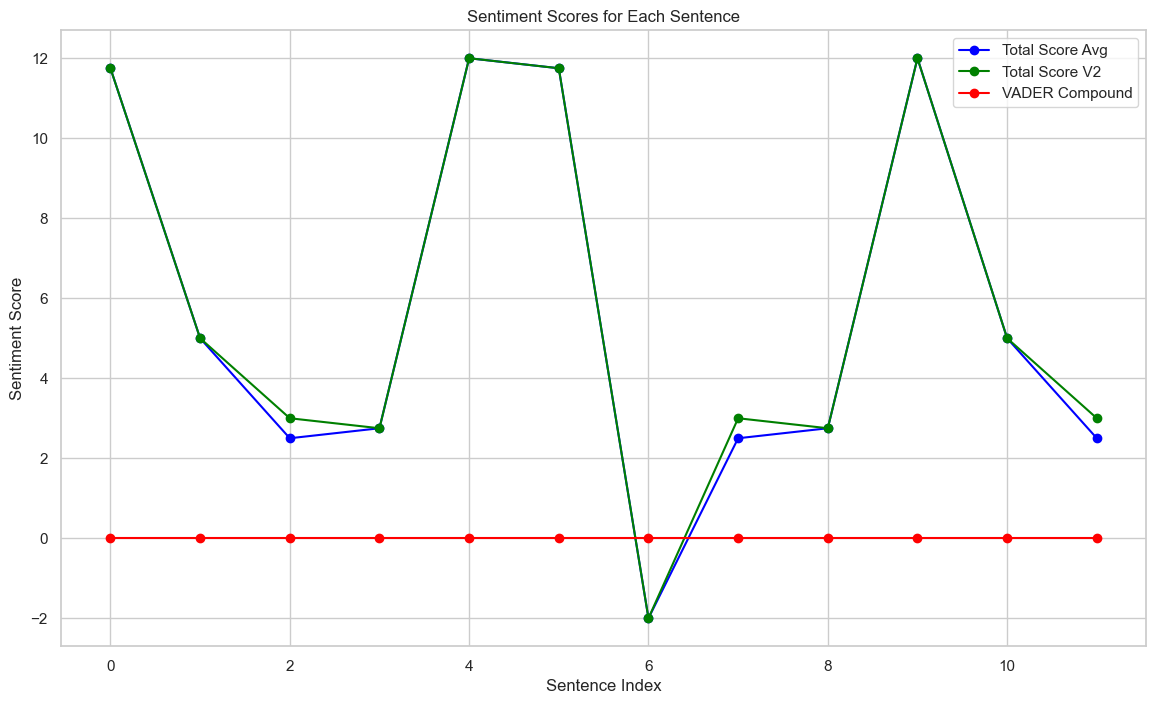

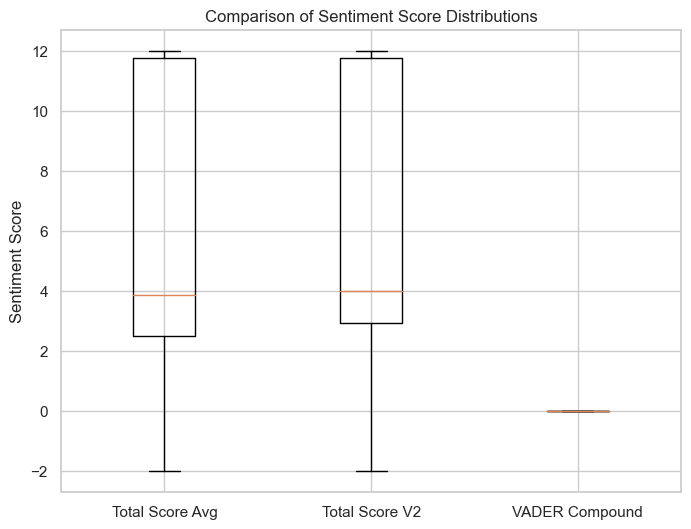

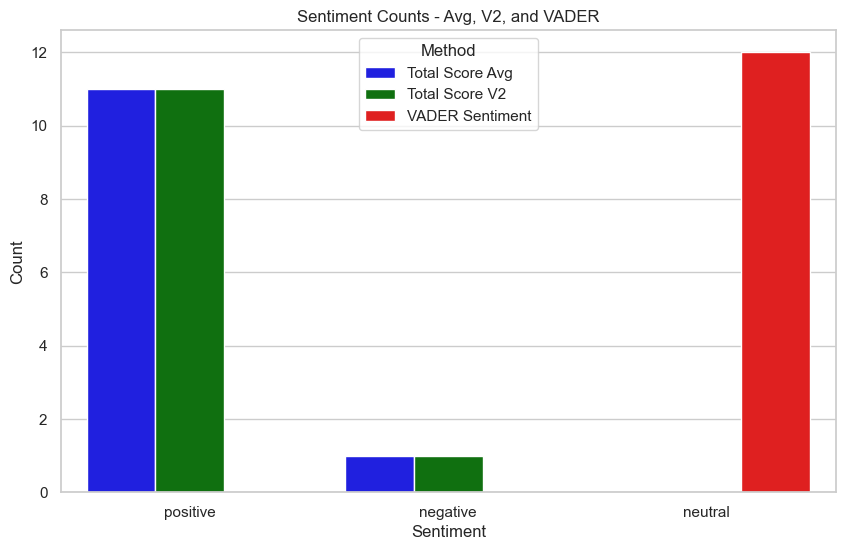

### Table 1: Translations


,sentence,source_language,target_language,translated_text
0,Ngiyabathanda abantu abazinakekelayo,zulu,english,i love them women those who are caring
1,kubalulekile ukuzinakekela,zulu,english,it's important to take care of oneself
2,yenza okufunayo,zulu,english,make what you want
3,uphatha kabi abantu,zulu,english,you treat badly women
4,uthanda izinto ezimbi,zulu,english,you like things bad things
5,Ngiyabathanda abantu abazinakekelayo,zulu,sepedi,ke a ba rata basadi bao ba kgathalago
6,Mase ubona engathi umuthanda kakhulu muyeke,zulu,sepedi,ge o bona bjalo ka o a mo rata ka bontši mo lese
7,yenza okufunayo,zulu,sepedi,dira se o nyakago
8,uphatha kabi abantu,zulu,sepedi,o swara gampe basadi
9,uthanda izinto ezimbi,zulu,sepedi,o rata dilo tše mpe


### Table 2: Sentiment Analysis Results


,total_score_avg,word_scores_avg,sentiment_avg,total_score_v2,word_scores_v2,sentiment_v2,vader_compound,vader_sentiment
0,11.75,ngiyabathanda:0; abantu:2.75; abazinakekelayo:9.0,positive,11.75,ngiyabathanda:0; abantu:2.75; abazinakekelayo:9,positive,0.0,neutral
1,5.00,kubalulekile:0.0; ukuzinakekela:5.0,positive,5.00,kubalulekile:0; ukuzinakekela:5,positive,0.0,neutral
2,2.50,yenza:2.5; okufunayo:0.0,positive,3.00,yenza:3; okufunayo:0,positive,0.0,neutral
3,2.75,uphatha:5.0; kabi:-5.0; abantu:2.75,positive,2.75,uphatha:5; kabi:-5; abantu:2.75,positive,0.0,neutral
4,12.00,uthanda:9.0; izinto:3.0; ezimbi:0,positive,12.00,uthanda:9; izinto:3; ezimbi:0,positive,0.0,neutral
5,11.75,ngiyabathanda:0; abantu:2.75; abazinakekelayo:9.0,positive,11.75,ngiyabathanda:0; abantu:2.75; abazinakekelayo:9,positive,0.0,neutral
6,-2.00,mase:0; ubona:0.0; engathi:0.0; umuthanda:-3.0...,negative,-2.00,mase:0; ubona:0; engathi:0; umuthanda:-3; kakh...,negative,0.0,neutral
7,2.50,yenza:2.5; okufunayo:0.0,positive,3.00,yenza:3; okufunayo:0,positive,0.0,neutral
8,2.75,uphatha:5.0; kabi:-5.0; abantu:2.75,positive,2.75,uphatha:5; kabi:-5; abantu:2.75,positive,0.0,neutral
9,12.00,uthanda:9.0; izinto:3.0; ezimbi:0,positive,12.00,uthanda:9; izinto:3; ezimbi:0,positive,0.0,neutral


In [10]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator

# Ensure plots are displayed inline in Jupyter Notebook
%matplotlib inline

# Set a style for seaborn plots
sns.set(style='whitegrid')

# -------------------- 1. Sentiment Scores Plot --------------------

# Plot sentiment scores for all sentences
plt.figure(figsize=(14, 8))
plt.plot(test_corpus_df.index, test_corpus_df['total_score_avg'], label='Total Score Avg', color='blue', marker='o')
plt.plot(test_corpus_df.index, test_corpus_df['total_score_v2'], label='Total Score V2', color='green', marker='o')
plt.plot(test_corpus_df.index, test_corpus_df['vader_compound'], label='VADER Compound', color='red', marker='o')
plt.title('Sentiment Scores for Each Sentence')
plt.xlabel('Sentence Index')
plt.ylabel('Sentiment Score')
plt.legend()
plt.grid(True)
plt.show()

# -------------------- 2. Box and Whisker Plots --------------------

# Box plots to compare the distributions
plt.figure(figsize=(8, 6))
data_to_plot = [
    test_corpus_df['total_score_avg'],
    test_corpus_df['total_score_v2'],
    test_corpus_df['vader_compound']
]
plt.boxplot(data_to_plot, labels=['Total Score Avg', 'Total Score V2', 'VADER Compound'])
plt.title('Comparison of Sentiment Score Distributions')
plt.ylabel('Sentiment Score')
plt.show()

# -------------------- 3. Sentiment Counts Plot --------------------

# Prepare data for sentiment counts by melting the DataFrame
count_data = pd.melt(
    test_corpus_df,
    value_vars=['sentiment_avg', 'sentiment_v2', 'vader_sentiment'],
    var_name='Method',
    value_name='Sentiment'
)

# Define a color palette for the different methods
palette = {
    'sentiment_avg': 'blue',
    'sentiment_v2': 'green',
    'vader_sentiment': 'red'
}

# Plot sentiment counts
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    x='Sentiment',
    hue='Method',
    data=count_data,
    palette=palette
)
plt.title('Sentiment Counts - Avg, V2, and VADER')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Ensure y-axis displays whole numbers
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Update legend labels
plt.legend(title='Method', labels=['Total Score Avg', 'Total Score V2', 'VADER Sentiment'])
plt.show()

# -------------------- 4. Remove Confusion Matrices --------------------
# (No action needed as confusion matrix code has been removed)

# -------------------- 5. Create Separate Tables --------------------

# Table 1: Translations
table1 = test_corpus_df[['sentence', 'source_language', 'target_language', 'translated_text']]
print("### Table 1: Translations")
display(table1.head(20))  # Displaying first 20 rows for brevity

# Table 2: Sentiment Analysis Results
table2 = test_corpus_df[[
    'total_score_avg',
    'word_scores_avg',
    'sentiment_avg',
    'total_score_v2',
    'word_scores_v2',
    'sentiment_v2',
    'vader_compound',
    'vader_sentiment'
]]
print("### Table 2: Sentiment Analysis Results")
display(table2.head(20))  # Displaying first 20 rows for brevity


In [11]:
import os
# Define the save directory
save_directory = r"C:\Users\ryand\Desktop\2024\Honours\Modules\S2\INF791\Assignment\Assignment 3\CHECKED Sentences\Tables\1\saved tables"

# Create the directory if it doesn't exist
os.makedirs(save_directory, exist_ok=True)

# Table 1: Translations
table1 = test_corpus_df[['sentence', 'source_language', 'target_language', 'translated_text']]
table1_filename = os.path.join(save_directory, 'translations_table.xlsx')
try:
    table1.to_excel(table1_filename, index=False)
    print(f"### Table 1: Translations saved to {table1_filename}")
except Exception as e:
    print(f"An error occurred while saving Table 1: {e}")
    
# Table 2: Sentiment Analysis Results
table2 = test_corpus_df[[
    'total_score_avg',
    'word_scores_avg',
    'sentiment_avg',
    'total_score_v2',
    'word_scores_v2',
    'sentiment_v2',
    'vader_compound',
    'vader_sentiment'
]]
table2_filename = os.path.join(save_directory, 'sentiment_analysis_table.xlsx')
try:
    table2.to_excel(table2_filename, index=False)
    print(f"### Table 2: Sentiment Analysis Results saved to {table2_filename}")
except Exception as e:
    print(f"An error occurred while saving Table 2: {e}")

# Display the tables in the notebook (optional)
print("### Table 1: Translations")
display(table1.head(30))  # Displaying first 20 rows for brevity

print("### Table 2: Sentiment Analysis Results")
display(table2.head(30))  # Displaying first 20 rows for brevity


### Table 1: Translations saved to C:\Users\ryand\Desktop\2024\Honours\Modules\S2\INF791\Assignment\Assignment 3\CHECKED Sentences\Tables\1\saved tables\translations_table.xlsx
### Table 2: Sentiment Analysis Results saved to C:\Users\ryand\Desktop\2024\Honours\Modules\S2\INF791\Assignment\Assignment 3\CHECKED Sentences\Tables\1\saved tables\sentiment_analysis_table.xlsx
### Table 1: Translations


,sentence,source_language,target_language,translated_text
0,Ngiyabathanda abantu abazinakekelayo,zulu,english,i love them women those who are caring
1,kubalulekile ukuzinakekela,zulu,english,it's important to take care of oneself
2,yenza okufunayo,zulu,english,make what you want
3,uphatha kabi abantu,zulu,english,you treat badly women
4,uthanda izinto ezimbi,zulu,english,you like things bad things
5,Ngiyabathanda abantu abazinakekelayo,zulu,sepedi,ke a ba rata basadi bao ba kgathalago
6,Mase ubona engathi umuthanda kakhulu muyeke,zulu,sepedi,ge o bona bjalo ka o a mo rata ka bontši mo lese
7,yenza okufunayo,zulu,sepedi,dira se o nyakago
8,uphatha kabi abantu,zulu,sepedi,o swara gampe basadi
9,uthanda izinto ezimbi,zulu,sepedi,o rata dilo tše mpe


### Table 2: Sentiment Analysis Results


,total_score_avg,word_scores_avg,sentiment_avg,total_score_v2,word_scores_v2,sentiment_v2,vader_compound,vader_sentiment
0,11.75,ngiyabathanda:0; abantu:2.75; abazinakekelayo:9.0,positive,11.75,ngiyabathanda:0; abantu:2.75; abazinakekelayo:9,positive,0.0,neutral
1,5.00,kubalulekile:0.0; ukuzinakekela:5.0,positive,5.00,kubalulekile:0; ukuzinakekela:5,positive,0.0,neutral
2,2.50,yenza:2.5; okufunayo:0.0,positive,3.00,yenza:3; okufunayo:0,positive,0.0,neutral
3,2.75,uphatha:5.0; kabi:-5.0; abantu:2.75,positive,2.75,uphatha:5; kabi:-5; abantu:2.75,positive,0.0,neutral
4,12.00,uthanda:9.0; izinto:3.0; ezimbi:0,positive,12.00,uthanda:9; izinto:3; ezimbi:0,positive,0.0,neutral
5,11.75,ngiyabathanda:0; abantu:2.75; abazinakekelayo:9.0,positive,11.75,ngiyabathanda:0; abantu:2.75; abazinakekelayo:9,positive,0.0,neutral
6,-2.00,mase:0; ubona:0.0; engathi:0.0; umuthanda:-3.0...,negative,-2.00,mase:0; ubona:0; engathi:0; umuthanda:-3; kakh...,negative,0.0,neutral
7,2.50,yenza:2.5; okufunayo:0.0,positive,3.00,yenza:3; okufunayo:0,positive,0.0,neutral
8,2.75,uphatha:5.0; kabi:-5.0; abantu:2.75,positive,2.75,uphatha:5; kabi:-5; abantu:2.75,positive,0.0,neutral
9,12.00,uthanda:9.0; izinto:3.0; ezimbi:0,positive,12.00,uthanda:9; izinto:3; ezimbi:0,positive,0.0,neutral
